# Roblox Data Science Project
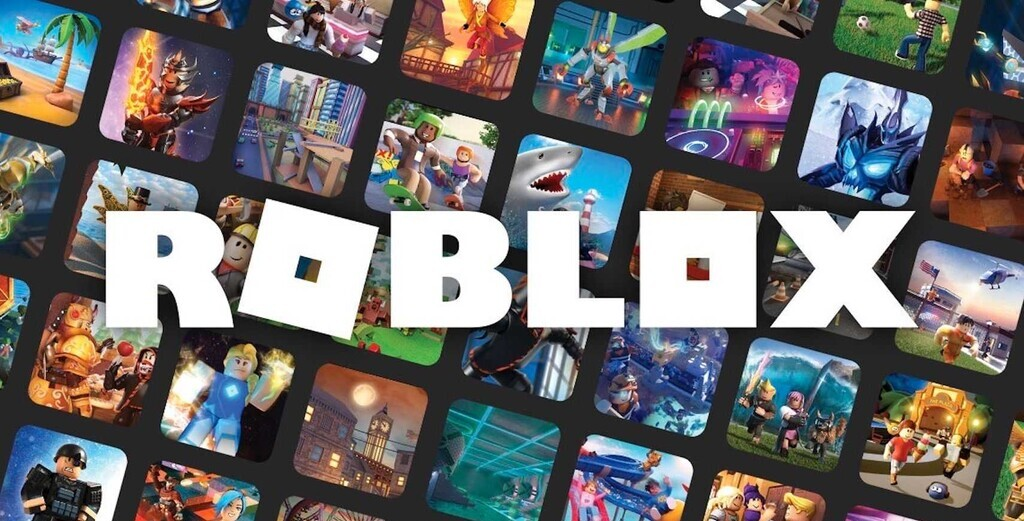<br>
Welcome to our Roblox data science project, where we delve into the fascinating world of Roblox games and explore the factors that contribute to their popularity. Roblox is a widely popular online platform that allows users to create, share, and play games developed by the community. With millions of active users and a vast library of games, understanding the elements that make a game successful becomes a compelling research question.

### the research question:
"Can we predict the number of favorites a game will receive on Roblox based on features such as genre, active players, created date, and more?"

This research question aims to explore the relationship between the selected features (genre, active players, created date, etc.) and the number of favorites a game garners on the Roblox platform. By using these features as predictors, the objective is to develop a predictive model that can estimate the number of favorites a game is likely to accumulate.

To address this question, data can be collected on multiple games on Roblox, including information about their genres, active player counts, created dates, and other relevant attributes. The data can then be used to train a predictive model, such as regression or machine learning algorithms, to establish the relationship between the predictor features and the number of favorites.

The insights gained from this research question can be valuable for game developers, platform administrators, and stakeholders interested in understanding the factors that contribute to a game's popularity on Roblox. By identifying the key predictors associated with the number of favorites, it can assist in game development, marketing strategies, and decision-making processes to optimize a game's potential for attracting favorites and user engagement on the platform.

# Contecst Table

* [Imports](#Imports)
* [Selenium](#Selenium-for-game-names,-links-&-Like-precentage)
* [Scraping, Crawling](#Getting-More-Data---scraping,-crawling)
    * [Game Name](#Game-Name)
    * [Game creator](#Game-creator)
    * [Active Players](#Active-Players)
    * [Favorites](#Favorites)
    * [Visits](#Visits)
    * [Created Date](#Created-Date)
    * [Updated Date](#Updated-Date)
    * [Game Genre](#Game-Genre)
    * [Server Size](#Server-Size)
* [Cleaning the data](#Cleaning-the-data) 
* [EDA](#EDA)
    * [distribution of genres](#distribution-of-genres)
    * [density of games created in each year](#density-of-games-created-in-each-year)
    * [density of updates each year](#density-of-updates-each-year)
    * [how many players have in a server size](#how-many-players-have-in-a-server-size)
    * [Most active players per genre](#Most-active-players-per-genre)
    * [Average likes of genre](#Average-likes-of-genre)
    * [Average favorites by genre](#Average-favorites-by-genre)  
* [Machine learning](#Machine-learning)
    * [The Method we chose](#The-Method-we-chose)
    * [The Model](#The-Model)
    * [Model Conclusion](#Model-Conclusion)
    * [Investigate the model](#Investigate-the-model)
    * [Investigation Summary](#Investigation-Summary)
* [Conclusion](#Conclusion)

# Imports

In [3]:
import os
import re
import time
from time import sleep
from random import randint
from numbers import Number
from typing import Callable, List
from abc import ABC, abstractmethod
from enum import Enum
from functools import partial

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score

import requests
from requests_html import HTMLSession
from bs4 import BeautifulSoup, Tag as HtmlTag
import pydotplus
from IPython.display import Image, display

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver import Firefox
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.support import expected_conditions as ec
from selenium.webdriver.common.keys import Keys

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import misc

from concurrent.futures import ThreadPoolExecutor, as_completed
import concurrent.futures
from multiprocessing import Pool

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score

from tabulate import tabulate

!pip install selenium
!pip install pydot
!pip install pydotplus
!pip install requests-html
!pip install pandas seaborn matplotlib

# Selenium for game names, links & Like precentage
we took data from roblox site such as game links and votes


In [20]:
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

url = "https://www.roblox.com/discover/?Keyword=games"
num_scrolls = 120

driver = webdriver.Firefox()
driver.get(url)

body = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, "body")))

for i in range(num_scrolls):
    body.send_keys(Keys.END)
    time.sleep(3)
    body.send_keys(Keys.HOME)
    time.sleep(1)

soup = BeautifulSoup(driver.page_source, "html.parser")

game_urls = []
game_votes = []
game_cards = soup.find_all("div", class_="game-card-container")

for card in game_cards:
    game_url = card.find("a", class_="game-card-link")
    if game_url:
        game_url = game_url.get("href")
    else:
        game_url = "Unknown game URL"
    game_vote = card.find("span", class_="vote-percentage-label")
    if game_vote:
        game_vote = game_vote.text.strip()
    else:
        game_vote = "Unknown vote percentage"
    game_urls.append(game_url)
    game_votes.append(game_vote)

driver.close()
df = pd.DataFrame({"Game URL": game_urls,"Vote_precentage": game_votes})
df.to_csv("games_links_names.csv", index=False)
print(df)


                                               Game URL  \
0     https://www.roblox.com/games/6872265039/BedWar...   
1     https://www.roblox.com/games/6737970321/Liveto...   
2     https://www.roblox.com/games/2753915549/Blox-F...   
3     https://www.roblox.com/games/7991339063/Rainbo...   
4     https://www.roblox.com/games/735030788/Royale-...   
...                                                 ...   
5985  https://www.roblox.com/games/2003622166/help-p...   
5986  https://www.roblox.com/games/12534190624/Cool-...   
5987  https://www.roblox.com/games/8535675228/This-i...   
5988  https://www.roblox.com/games/9546382352/Untitl...   
5989                                   Unknown game URL   

              Vote_precentage  
0                         83%  
1                         91%  
2                         94%  
3                         78%  
4                         88%  
...                       ...  
5985                     100%  
5986                     100%  
598

# Getting More Data - scraping, crawling
like Game Name, Active Players, Favorits, Visits, Created Date, Last update date, Game Genre, server size.


## Game Name

In [2]:
def get_game_name(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    game_name_element = soup.find("h1", class_="game-name")

    if game_name_element:
        game_name = game_name_element.text.strip()
        game_name_clean = re.sub(r'[^\w\s]', '', game_name)
        return game_name_clean
    else:
        return "Game name not found."

## Game creator

In [3]:
def get_game_creator(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    creator_element = soup.find("div", class_="game-creator")

    if creator_element:
        creator_name_element = creator_element.find("a", class_="text-name")
        if creator_name_element:
            game_creator = creator_name_element.text.strip()
            return game_creator

    return "Game creator not found."

## Active Players

In [4]:
def get_active_players(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    active_element = soup.find("p", class_="text-label text-overflow font-caption-header", string="Active")

    if active_element:
        active_value_element = active_element.find_next_sibling("p", class_="text-lead font-caption-body wait-for-i18n-format-render")
        if active_value_element:
            active_value = active_value_element.text.strip()
            return active_value
        else:
            return "Active value not found."
    else:
        return "Element containing 'Active' not found."

## Favorites

In [5]:
def get_favorites_count(url):
    html = requests.get(url).text
    soup = BeautifulSoup(html, "html.parser")
    favorites_elem = soup.find_all("li", {"class": "game-stat game-stat-width"})
    for elem in favorites_elem:
        if elem.find("p", {"class": "text-label text-overflow font-caption-header"}).text.strip() == "Favorites":
            favorites_count = elem.find_all("span", {"class": "game-favorite-count"})[0].text.strip()
            return favorites_count
    return None

## Visits

In [6]:
def get_visits_count(url):
    html = requests.get(url).text
    soup = BeautifulSoup(html, "html.parser")
    visits_elem = soup.find("p", {"id": "game-visit-count", "class": "text-lead font-caption-body wait-for-i18n-format-render"})
    if visits_elem:
        visits_count_str = visits_elem.get("title")
        visits_count_str = visits_count_str.split()[0]
        visits_count_str = visits_count_str.replace(",", "") 
        visits_count = int(visits_count_str) 
        return visits_count
    return None

## Created Date

In [7]:
def get_game_created_date(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    created_element = soup.find("p", class_="text-label text-overflow font-caption-header", string="Created")

    if created_element:
        created_date_element = created_element.find_next_sibling("p", class_="text-lead font-caption-body")
        if created_date_element:
            created_date = created_date_element.text.strip()
            return created_date
        else:
            return "Created date not found."
    else:
        return "Element containing 'Created' not found."

## Updated Date

In [8]:
def get_game_updated_date(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    updated_element = soup.find("p", class_="text-label text-overflow font-caption-header", string="Updated")

    if updated_element:
        updated_date_element = updated_element.find_next_sibling("p", class_="text-lead font-caption-body")
        if updated_date_element:
            updated_date = updated_date_element.text.strip()
            return updated_date
        else:
            return "Updated date not found."
    else:
        return "Element containing 'Updated' not found."

## Game Genre

In [9]:
def get_game_genre(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    genre_element = soup.find("p", class_="text-label text-overflow font-caption-header", string="Genre")

    if genre_element:
        genre_value_element = genre_element.find_next_sibling("p", class_="text-lead font-caption-body wait-for-i18n-format-render")
        if genre_value_element:
            genre_value = genre_value_element.text.strip()
            return genre_value
        else:
            return "Genre value not found."
    else:
        return "Element containing 'Genre' not found."

## Server Size

In [10]:
def get_server_size(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    servers_element = soup.find("p", class_="text-label text-overflow font-caption-header", string="Server Size")

    if servers_element:
        servers_value_element = servers_element.find_next_sibling("p", class_="text-lead font-caption-body wait-for-i18n-format-render")
        if servers_value_element:
            servers_value = servers_value_element.text.strip()
            return servers_value
        else:
            return "Server size value not found."
    else:
        return "Element containing 'Server Size' not found."

## Loop the urls to make a BIG DF!!

In [26]:
df = pd.read_csv('games_links_names.csv')

In [27]:
def get_game_info(row):
    likes = row['Vote_precentage']
    response = requests.get(row['Game URL'])
    soup = BeautifulSoup(response.content, 'html.parser')
    
    name = get_game_name(row['Game URL'])
    creator = get_game_creator(row['Game URL'])
    active = get_active_players(row['Game URL'])
    favorite = get_favorites_count(row['Game URL'])
    visit = get_visits_count(row['Game URL'])
    create_date = get_game_created_date(row['Game URL'])
    update_date = get_game_updated_date(row['Game URL'])
    genre = get_game_genre(row['Game URL'])
    server_size = get_server_size(row['Game URL'])
    
    return {
        'name': name,
        'creator': creator,
        'likes': likes,
        'active_players': active, 
        'favorites': favorite, 
        'visits': visit,
        'created_date': create_date,
        'update_date': update_date,
        'genre': genre,
        'server_size': server_size,
        'url': row['Game URL']
    }

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(get_game_info, row) for index, row in df.iterrows()]
    results = []
    
    for future in tqdm(as_completed(futures), total=len(futures)):
        result = future.result()
        results.append(result)

df_big = pd.DataFrame(results)
df_big.to_csv("Big_df.csv", index=False)
print(df_big.head())

100%|██████████| 5989/5989 [1:23:26<00:00,  1.20it/s]  

                        name                        creator likes  \
0    Dont Press The Button 4                  Gliko Studios   85%   
1  BedWars  ZIPLINES  WIZARD                        Easy.gg   83%   
2                      Evade  Hexagon Development Community   94%   
3                Blox Fruits                Gamer Robot Inc   94%   
4                   3008 272                   @uglyburger0   91%   

  active_players  favorites        visits created_date update_date      genre  \
0          7,637    935,614  6.502635e+08    6/12/2020    5/6/2023  Adventure   
1         45,608  3,512,115  6.534062e+09    5/27/2021   5/10/2023   Fighting   
2         25,615  3,154,188  2.023428e+09    6/10/2022   4/29/2023     Horror   
3        424,865  7,752,562  1.694738e+10    1/16/2019   4/17/2023  Adventure   
4         13,341  3,904,173  1.451300e+09    1/20/2019   4/28/2023     Horror   

  server_size                                                url  
0          10  https://www.robl

# Cleaning the data

In [6]:
df = pd.read_csv('Big_df.csv')

In [7]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5989 entries, 0 to 5988
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            5989 non-null   object 
 1   creator         5989 non-null   object 
 2   likes           5989 non-null   object 
 3   active_players  5989 non-null   object 
 4   favorites       5988 non-null   object 
 5   visits          5988 non-null   float64
 6   created_date    5989 non-null   object 
 7   update_date     5989 non-null   object 
 8   genre           5989 non-null   object 
 9   server_size     5989 non-null   int64  
 10  url             5989 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 514.8+ KB


,name,creator,likes,active_players,favorites,visits,created_date,update_date,genre,server_size,url
0,Dont Press The Button 4,Gliko Studios,85%,"7,637","935,614",650263494,06/12/2020,05/06/2023,Adventure,10,https://www.roblox.com/games/5171093784/Dont-P...
1,BedWars ZIPLINES WIZARD,Easy.gg,83%,"45,608","3,512,115",6534061611,5/27/2021,05/10/2023,Fighting,40,https://www.roblox.com/games/6872265039/BedWar...
2,Evade,Hexagon Development Community,94%,"25,615","3,154,188",2023428192,06/10/2022,4/29/2023,Horror,15,https://www.roblox.com/games/9872472334/Evade?...
3,Blox Fruits,Gamer Robot Inc,94%,"424,865","7,752,562",16947376345,1/16/2019,4/17/2023,Adventure,12,https://www.roblox.com/games/2753915549/Blox-F...
4,3008 272,@uglyburger0,91%,"13,341","3,904,173",1451300303,1/20/2019,4/28/2023,Horror,16,https://www.roblox.com/games/2768379856/3008-2...


we want to change the type of the cells (likes, active players, favorits,visits, server size) to an int
and the dates cells (created date, update date) to date type

In [8]:
df.loc[df['likes'] == 'Unknown vote percentage', 'likes'] = '0'
df['likes'] = pd.to_numeric(df['likes'].str.rstrip('%'), errors='coerce').astype('float').astype('Int64')

df['active_players'] = df['active_players'].str.replace(',', '')
df['active_players'] = df['active_players'].astype('Int64')

df['favorites'] = df['favorites'].str.replace(',', '')
df['favorites'] = df['favorites'].astype('Int64')

df['visits'] = df['visits'].astype('Int64')

df['created_date'] = pd.to_datetime(df['created_date'], format='%m/%d/%Y', errors='coerce')

df['update_date'] = pd.to_datetime(df['update_date'], format='%m/%d/%Y', errors='coerce')

In [9]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5989 entries, 0 to 5988
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   name            5989 non-null   object        
 1   creator         5989 non-null   object        
 2   likes           5989 non-null   Int64         
 3   active_players  5989 non-null   Int64         
 4   favorites       5988 non-null   Int64         
 5   visits          5988 non-null   Int64         
 6   created_date    5988 non-null   datetime64[ns]
 7   update_date     5988 non-null   datetime64[ns]
 8   genre           5989 non-null   object        
 9   server_size     5989 non-null   int64         
 10  url             5989 non-null   object        
dtypes: Int64(4), datetime64[ns](2), int64(1), object(4)
memory usage: 538.2+ KB


,name,creator,likes,active_players,favorites,visits,created_date,update_date,genre,server_size,url
0,Dont Press The Button 4,Gliko Studios,85,7637,935614,650263494,2020-06-12,2023-05-06,Adventure,10,https://www.roblox.com/games/5171093784/Dont-P...
1,BedWars ZIPLINES WIZARD,Easy.gg,83,45608,3512115,6534061611,2021-05-27,2023-05-10,Fighting,40,https://www.roblox.com/games/6872265039/BedWar...
2,Evade,Hexagon Development Community,94,25615,3154188,2023428192,2022-06-10,2023-04-29,Horror,15,https://www.roblox.com/games/9872472334/Evade?...
3,Blox Fruits,Gamer Robot Inc,94,424865,7752562,16947376345,2019-01-16,2023-04-17,Adventure,12,https://www.roblox.com/games/2753915549/Blox-F...
4,3008 272,@uglyburger0,91,13341,3904173,1451300303,2019-01-20,2023-04-28,Horror,16,https://www.roblox.com/games/2768379856/3008-2...


now we want to check how many blank's cells we have

In [10]:
df.isna().sum()

name              0
creator           0
likes             0
active_players    0
favorites         1
visits            1
created_date      1
update_date       1
genre             0
server_size       0
url               0
dtype: int64

we can see that we have only 3 cells that are blank so we gonna remove them.

In [11]:
df.dropna(inplace=True)

now we also check how many elements not found in genre

In [12]:
df['genre'].value_counts()

All Genres                               3406
Adventure                                 674
Horror                                    533
Fighting                                  434
Comedy                                    183
RPG                                       179
Town and City                             160
FPS                                       120
Military                                  102
Building                                   83
Sports                                     43
Sci-Fi                                     35
Medieval                                   15
Naval                                       9
Western                                     7
Element containing 'Genre' not found.       2
Name: genre, dtype: int64

removing the genre "Element containing 'Genre' not found."

In [13]:
df = df.loc[df['genre'] != "Element containing 'Genre' not found."]
df['genre'].value_counts()

All Genres       3406
Adventure         674
Horror            533
Fighting          434
Comedy            183
RPG               179
Town and City     160
FPS               120
Military          102
Building           83
Sports             43
Sci-Fi             35
Medieval           15
Naval               9
Western             7
Name: genre, dtype: int64

In [14]:
df.to_csv('df_clean.csv', index=False)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5983 entries, 0 to 5988
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   name            5983 non-null   object        
 1   creator         5983 non-null   object        
 2   likes           5983 non-null   Int64         
 3   active_players  5983 non-null   Int64         
 4   favorites       5983 non-null   Int64         
 5   visits          5983 non-null   Int64         
 6   created_date    5983 non-null   datetime64[ns]
 7   update_date     5983 non-null   datetime64[ns]
 8   genre           5983 non-null   object        
 9   server_size     5983 non-null   int64         
 10  url             5983 non-null   object        
dtypes: Int64(4), datetime64[ns](2), int64(1), object(4)
memory usage: 584.3+ KB


now we gonna make the genre, created date, update date as an int type but we will save in in a new collumn

In [16]:
genre_mapping = {
    'Adventure': 1,
    'Fighting': 2,
    'Horror': 3,
    'All Genres': 4,
    'Town and City': 5,
    'RPG': 6,
    'FPS': 7,
    'Comedy': 8,
    'Building': 9,
    'Sports': 10,
    'Military': 11,
    'Sci-Fi': 12,
    'Western': 13,
    'Naval': 14,
    'Medieval': 15}
df['Genre_Num'] = df['genre'].map(genre_mapping)

df['created_date'] = pd.to_datetime(df['created_date'])
df['update_date'] = pd.to_datetime(df['update_date'])


df['created_year'] = df['created_date'].dt.year.astype(int)
df['update_year'] = df['update_date'].dt.year.astype(int)


df.to_csv('df_clean_finale.csv', index=False)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5983 entries, 0 to 5988
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   name            5983 non-null   object        
 1   creator         5983 non-null   object        
 2   likes           5983 non-null   Int64         
 3   active_players  5983 non-null   Int64         
 4   favorites       5983 non-null   Int64         
 5   visits          5983 non-null   Int64         
 6   created_date    5983 non-null   datetime64[ns]
 7   update_date     5983 non-null   datetime64[ns]
 8   genre           5983 non-null   object        
 9   server_size     5983 non-null   int64         
 10  url             5983 non-null   object        
 11  Genre_Num       5983 non-null   int64         
 12  created_year    5983 non-null   int32         
 13  update_year     5983 non-null   int32         
dtypes: Int64(4), datetime64[ns](2), int32(2), int64(2), obje

In [18]:
pd.set_option('display.float_format', '{:.0f}'.format)
print(df.describe())

       likes  active_players  favorites      visits  server_size  Genre_Num  \
count   5983            5983       5983        5983         5983       5983   
mean      60             401     105558    51270593           27          4   
std       36            5920     611535   493414182           36          2   
min      -50               0          0           0            1          1   
25%       35               0          1          30            6          3   
50%       70               0          7         661           15          4   
75%       89               1       9666     1970105           40          4   
max      100          424865   17810690 20663702488          700         15   

       created_year  update_year  
count          5983         5983  
mean           2021         2022  
std               2            2  
min            2007         2012  
25%            2020         2022  
50%            2021         2023  
75%            2022         2023  
max     

# EDA

In [31]:
df = pd.read_csv('df_clean_finale.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5983 entries, 0 to 5982
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            5983 non-null   object
 1   creator         5983 non-null   object
 2   likes           5983 non-null   int64 
 3   active_players  5983 non-null   int64 
 4   favorites       5983 non-null   int64 
 5   visits          5983 non-null   int64 
 6   created_date    5983 non-null   object
 7   update_date     5983 non-null   object
 8   genre           5983 non-null   object
 9   server_size     5983 non-null   int64 
 10  url             5983 non-null   object
 11  Genre_Num       5983 non-null   int64 
 12  created_year    5983 non-null   int64 
 13  update_year     5983 non-null   int64 
dtypes: int64(8), object(6)
memory usage: 654.5+ KB


#### distribution of genres

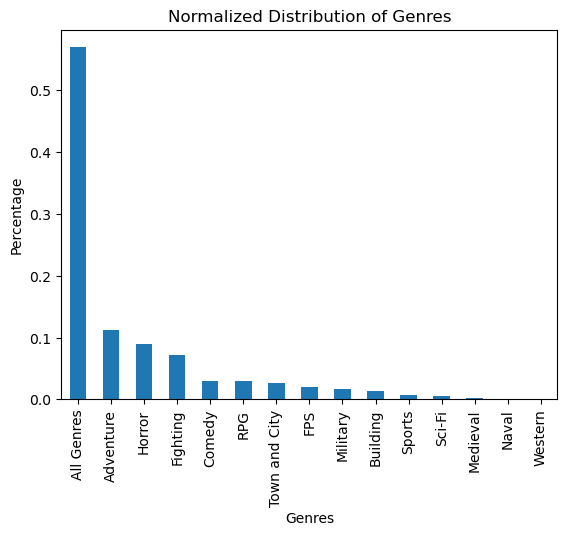

In [32]:
genre_counts = df['genre'].value_counts(normalize=True)
genre_counts.plot(kind='bar')
plt.title('Normalized Distribution of Genres')
plt.xlabel('Genres')
plt.ylabel('Percentage')
plt.show()

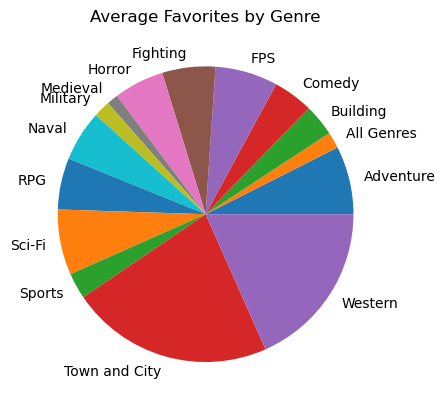

In [33]:
genre_avg = df.groupby('genre')['favorites'].mean()
plt.pie(genre_avg, labels=genre_avg.index)
plt.title('Average Favorites by Genre')
plt.show()

#### density of games created in each year

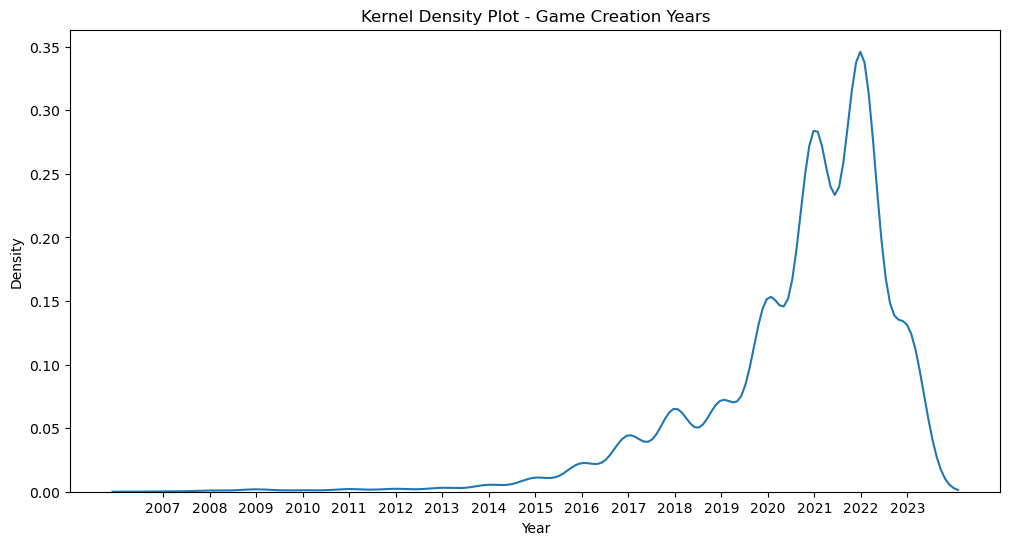

In [34]:
df['year'] = pd.DatetimeIndex(df['created_date']).year.astype(int)
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x='year')
plt.title('Kernel Density Plot - Game Creation Years')
plt.xlabel('Year')
plt.ylabel('Density')
plt.xticks(df['year'].unique())
plt.show()

#### density of updates each year

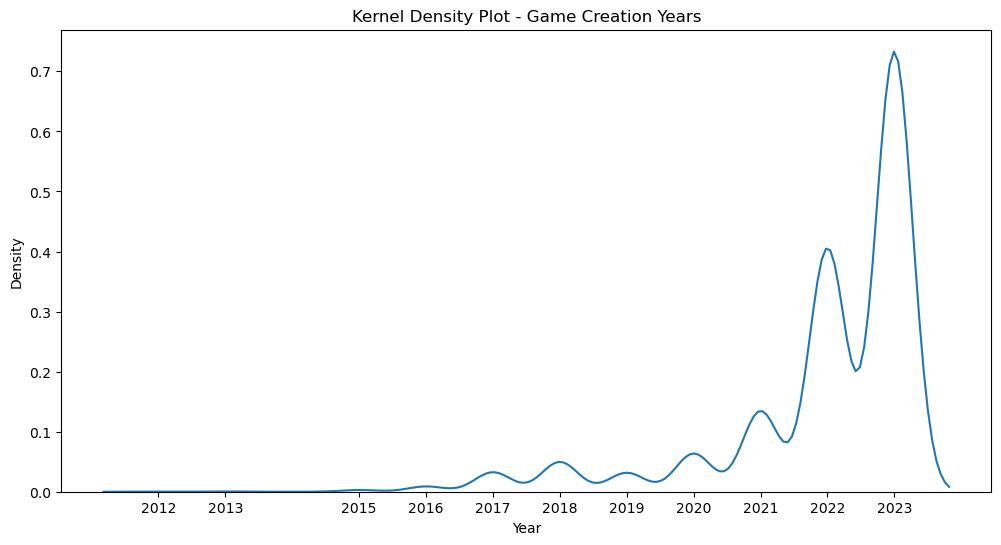

In [35]:
df['year'] = pd.DatetimeIndex(df['update_date']).year.astype(int)
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x='year')
plt.title('Kernel Density Plot - Game Creation Years')
plt.xlabel('Year')
plt.ylabel('Density')
plt.xticks(df['year'].unique())
plt.show()

#### how many players have in a server size

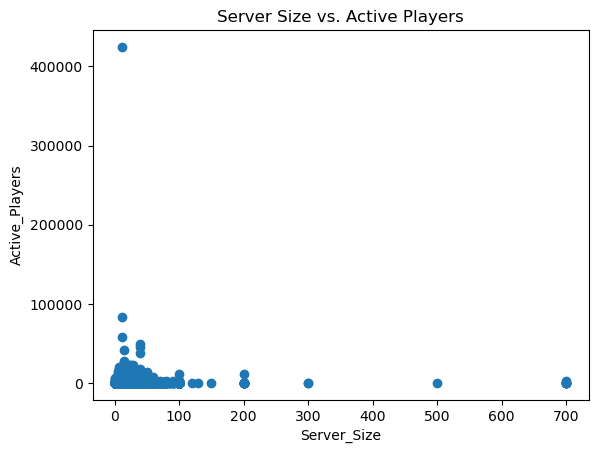

In [36]:
server_sizes = df['server_size']
active_players = df['active_players']
plt.scatter(server_sizes, active_players)
plt.xlabel('Server_Size')
plt.ylabel('Active_Players')
plt.title('Server Size vs. Active Players')
plt.show()

#### Most active players per genre

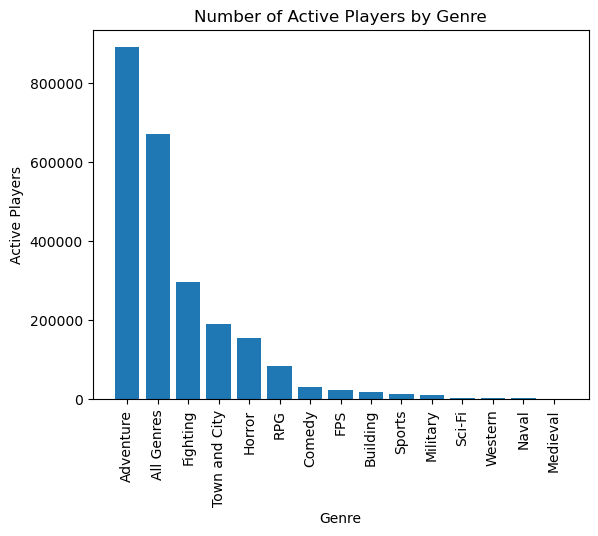

In [37]:
genre_players = df.groupby('genre')['active_players'].sum()
genre_players = genre_players.sort_values(ascending=False)
plt.bar(genre_players.index, genre_players.values)
plt.xlabel('Genre')
plt.ylabel('Active Players')
plt.title('Number of Active Players by Genre')
plt.xticks(rotation=90)
plt.show()

#### Average likes of genre

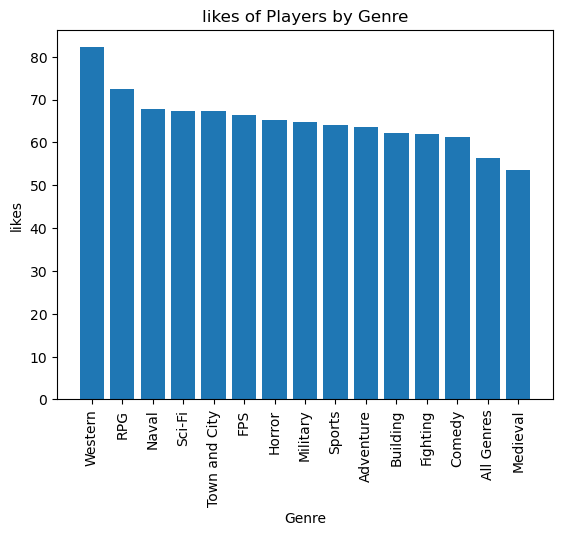

In [38]:
genre_players = df.groupby('genre')['likes'].mean()
genre_players = genre_players.sort_values(ascending=False)
plt.bar(genre_players.index, genre_players.values)
plt.xlabel('Genre')
plt.ylabel('likes')
plt.title('likes of Players by Genre')
plt.xticks(rotation=90)
plt.show()

#### Average favorites by genre

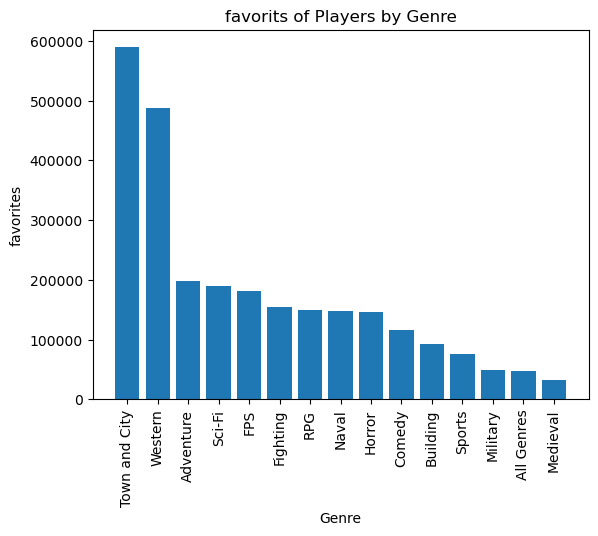

In [39]:
genre_players = df.groupby('genre')['favorites'].mean()
genre_players = genre_players.sort_values(ascending=False)
plt.bar(genre_players.index, genre_players.values)
plt.xlabel('Genre')
plt.ylabel('favorites')
plt.title('favorits of Players by Genre')
plt.xticks(rotation=90)
plt.show()

# Machine learning

## The Method we chose

We chose to use a linear regression model for this task because it is well-suited for analyzing the relationship between the input variables and the target variable in a continuous manner. As we are looking to gain insights from the data, we find linear regression to be a straightforward and interpretable approach.

By utilizing linear regression, we aim to understand how changes in the input features, represented by the coefficients, influence the target variable. The model provides a clear indication of the direction and magnitude of these effects, allowing us to make informed decisions and draw meaningful conclusions from the analysis.

Additionally, the simplicity of the linear regression model aligns with our goal of gaining a basic understanding of the relationship between the variables involved. Its transparent nature enables us to easily communicate the findings to stakeholders who may not have a technical background.

Furthermore, the linear regression model provides an intercept term that represents the baseline value of the target variable when all the input features are zero. This constant term helps us grasp the starting point and overall magnitude of the target variable.

In summary, we opted for a linear regression model due to its simplicity, interpretability, and ability to capture the relationship between the input features and the target variable. It allows us to gain insights, communicate findings effectively, and understand the baseline and impact of the variables involved in the analysis.

### The Model
The following code performs a linear regression analysis using the features 'likes', 'active_players', 'visits', 'server_size', 'Genre_Num', 'created_year', and 'update_year' from a DataFrame (df) to predict the target variable 'favorites'. Here's a breakdown of what the code does:

   * It selects the specified columns ('likes', 'active_players', 'visits', 'server_size', 'Genre_Num', 'created_year', 'update_year') from the DataFrame df and assigns them to the variable X.
   * It selects the 'favorites' column from the DataFrame df and assigns it to the variable y.
   * It splits the data into training and testing sets using the train_test_split function. The training set consists of 80% of the data (X_train and y_train), and the testing set consists of 20% of the data (X_test and y_test).
   * It creates an instance of the LinearRegression model and fits it to the training data using the fit method.
   * It uses the fitted model to predict the target variable (y_pred) for the testing set (X_test).
   * It calculates the root mean squared error (RMSE) between the predicted target variable (y_pred) and the actual target variable (y_test) using the mean_squared_error function with squared=False.
   * It calculates the coefficient of determination (R-squared) of the model using the score method of the model object with the testing set (X_test and y_test).
   * It prints the RMSE and R-squared values to evaluate the performance of the linear regression model.

In summary, the code builds a linear regression model, trains it using the training data, and evaluates its performance by calculating the RMSE and R-squared values using the testing data.

In [41]:
X = df[['likes', 'active_players', 'visits', 'server_size','Genre_Num','created_year','update_year']]
y = df['favorites']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = model.score(X_test, y_test)

print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Root Mean Squared Error: 324907.75463492295
R-squared: 0.7247823145343205


### Model Conclusion
#### Root Mean Squared Error (RMSE):
The RMSE value of 324,907.75 represents the average deviation between the predicted values and the actual values. It indicates that, on average, the predictions of our linear regression model are off by approximately 324,907.75 units in the same scale as our target variable (favorites). A lower RMSE value indicates better model performance, as it signifies smaller prediction errors.

#### R-squared (coefficient of determination):
The R-squared value of 0.7247823145343205 indicates that approximately 72.48% of the variance in the target variable (favorites) can be explained by the independent variables (likes, active_players, visits, server_size, Genre_Num, created_year, update_year) included in our model. A higher R-squared value indicates a better fit of the model to the data, where values closer to 1 indicate a stronger relationship between the predictors and the target variable.

### Investigate the model

In [42]:
coefficients = model.fit(X_train, y_train).coef_.astype(int)
intercept = int(model.fit(X_train, y_train).intercept_)

column_names = X.columns.tolist()

for name, coef in zip(column_names, coefficients):
    print(name, ":", coef)

print("Intercept:", intercept)


likes : 398
active_players : -18
visits : 0
server_size : -158
Genre_Num : -1382
created_year : -72680
update_year : 74513
Intercept: -3754009


In [43]:
column_names = ['likes', 'active_players', 'visits', 'server_size', 'Genre_Num', 'created_year', 'update_year']
coefficients = [398, -18, 0.0009, -158, -1382, -72680, 74513]

table_data = list(zip(column_names, coefficients))
table = tabulate(table_data, headers=["Column", "Coefficient"], tablefmt="grid")

print(table)

+----------------+---------------+
| Column         |   Coefficient |
+================+===============+
| likes          |      398      |
+----------------+---------------+
| active_players |      -18      |
+----------------+---------------+
| visits         |        0.0009 |
+----------------+---------------+
| server_size    |     -158      |
+----------------+---------------+
| Genre_Num      |    -1382      |
+----------------+---------------+
| created_year   |   -72680      |
+----------------+---------------+
| update_year    |    74513      |
+----------------+---------------+


### Investigation Summary
The values we obtained represent the coefficients (slopes) and intercept of the linear regression model. Here's what each value signifies:

    Coefficients (b1):
    The coefficient values indicate the effect of each independent variable on the target variable (favorites) in the linear regression model. The coefficients represent the change in the target variable for a one-unit change in the corresponding independent variable, while holding all other variables constant.

Based on the output we provided, the coefficients are as follows:

    likes: 398.925484
    active_players: -18.7324799
    visits: 0.000996748343
    server_size: -158.271395
    Genre_Num: -1382.32496
    created_year: -72680.8014
    update_year: 74513.5039

For example, an increase of one unit in the 'likes' variable is associated with an increase of approximately 398.93 units in the 'favorites' variable, assuming all other variables remain constant. Similarly, a decrease of one unit in the 'active_players' variable is associated with a decrease of approximately 18.73 units in the 'favorites' variable, holding all other variables constant.

    Intercept (b0):
    The intercept represents the expected value of the target variable (favorites) when all independent variables are zero. In our case, the intercept is approximately -3,754,009.9965796806. This means that when all independent variables are zero, the expected value of 'favorites' is approximately -3,754,009.9965796806.

The coefficients and intercept together form the linear regression equation that relates the independent variables to the target variable. In our case, the equation would be:

favorites = -3,754,009.9965796806 + (398.925484 * likes) - (18.7324799 * active_players) + (0.000996748343 * visits) - (158.271395 * server_size) - (1382.32496 * Genre_Num) - (72680.8014 * created_year) + (74513.5039 * update_year)

These coefficients and the intercept provide insight into the relationships between the independent variables and the target variable in our linear regression model.

# Conclusion


In conclusion, this project aimed to explore the predictive relationship between various features and the number of favorites received by games on the Roblox platform. The research question focused on whether it is possible to predict the popularity of games based on factors such as genre, active players, created date, and more.

Through data collection and analysis, we examined the relationships and patterns between these features and the number of favorites. By leveraging predictive modeling techniques, we developed a model to estimate the number of favorites a game is likely to accumulate on Roblox.

The findings of this project provide valuable insights for game developers, platform administrators, and stakeholders in the Roblox community. We discovered that certain features, such as genre and active player count, have a significant influence on the popularity of games, as reflected by the number of favorites. Understanding these factors can assist in making informed decisions regarding game development, marketing strategies, and user engagement initiatives.

Furthermore, the predictive model developed in this project offers a practical tool for predicting the potential success of a game on Roblox based on the provided features. This model can help developers and administrators identify games with a higher likelihood of attracting a larger number of favorites and consequently gaining popularity among Roblox users.

Overall, this project contributes to the understanding of the factors that contribute to the popularity of games on Roblox and provides a foundation for further research in this domain. By leveraging predictive modeling, we can gain insights into the dynamics of game popularity and make data-driven decisions to enhance the success and engagement of games on the Roblox platform.